In [ ]:
# first we import every library we're gonna use 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import time

In [ ]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 93.1MB/s]


## ***step 1) data visualization and preprocessing***

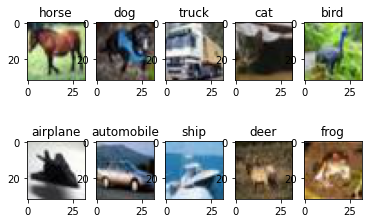

In [ ]:
# ploting first image of each class of train folder using matplotlib

train_path = '/content/CIFAR10/train' # Path of training folder
test_path = '/content/CIFAR10/test' #Path of testing folder
counter = 0
for dir in os.listdir(train_path):
  imgPath = os.path.join(train_path, dir) + '/0000.jpg'
  img = mpimg.imread(imgPath)
  ax = plt.subplot(2, 5, counter+1)
  ax.title.set_text(dir)
  plt.imshow(img)
  counter += 1

In [ ]:
nTrain = 20000 # Number of images in the training folder
nTest = 4000 # Number of images in the testing folder
train_data = np.zeros((nTrain, 32, 32, 3))  
test_data = np.zeros((nTest, 32, 32, 3))    
train_labels = np.zeros((20000, 4))
test_labels = np.zeros((4000, 4)) 

counter1 = 0
counter2 = 0

classes =  os.listdir(train_path)
for i in range(4): # filling arrays using dataset
  for file in os.listdir(os.path.join(train_path, classes[i])):
    img = mpimg.imread(os.path.join(train_path, classes[i])+'/'+file)
    train_data[counter1] = img
    train_labels[counter1][i] = 1
    counter1 += 1

  for file in os.listdir(os.path.join(test_path, classes[i])):
    img = mpimg.imread(os.path.join(test_path, classes[i])+'/'+file)
    test_data[counter2] = img
    test_labels[counter2][i] = 1
    counter2 += 1

Text(0.5, 1.0, 'gray-sclaled')

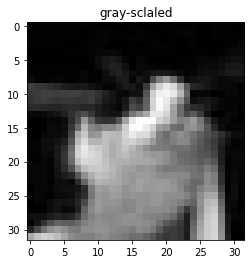

In [ ]:
# gray scaling

def rgb2gray(rgb):
 r, g, b = rgb[ :, :, :, 0], rgb[ :, :, :,1], rgb[ :, :, :, 2]
 gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
 #print(np.shape(gray))
 return gray

gray_train_data = rgb2gray(train_data)
gray_test_data = rgb2gray(test_data)
plt.imshow(gray_train_data[15000], cmap='gray',vmin=0, vmax=255)
plt.title("gray-sclaled")



In [ ]:
# normalizng data
gray_train_data = np.divide(gray_train_data, 255)
gray_test_data = np.divide(gray_test_data, 255)

In [ ]:
# flattening data
print('shape of gray scaled train data before flattening:',np.shape(gray_train_data))
print('shape of gray scaled test data  before flattening:',np.shape(gray_test_data))
gray_train_data = gray_train_data.reshape(-1, 1024)
gray_test_data = gray_test_data.reshape(-1, 1024)
print('shape of gray scaled train data after flattening:',np.shape(gray_train_data))
print('shape of gray scaled test data after flattening:',np.shape(gray_test_data))

shape of gray scaled train data before flattening: (20000, 32, 32)
shape of gray scaled test data  before flattening: (4000, 32, 32)
shape of gray scaled train data after flattening: (20000, 1024)
shape of gray scaled test data after flattening: (4000, 1024)


In [ ]:
# shuffling data
def shuffle_together(a, b):
    assert len(a) == len(b) # if len (a) != len(b) this function wont work properly
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation): 
      # first output of enumerate is a counter that shows index of each element in enumeration list
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

gray_train_data, train_labels = shuffle_together(gray_train_data, train_labels)
gray_test_data, test_labels = shuffle_together(gray_test_data, test_labels)

## ***step 2) feedforwarding***

In [ ]:
# creating weight and bias matrixes and initializing them

def param_initializer(dimention):
  weights = []
  biases = []
  mean = 0
  std = 1

  for i in range(len(dimention)-1):
    wShape = (dimention[i+1], dimention[i])
    bShape = (dimention[i+1], 1)
    weights.append(['W' + str(i+1) + str(i+2), np.random.normal(mean, std, wShape)])
    biases.append(['B'+ str(i+1), np.zeros(bShape)])
  return weights, biases

weights, biases = param_initializer([1024, 16, 16, 4])

print('Shape of Weights between 1st and 2nd layer is', np.shape(weights[0][1]))
print('Shape of biases for 2nd layer is',np.shape(biases[0][1]))
print('Shape of Weights between 2nd and 3rd layer is', np.shape(weights[1][1]))
print('Shape of biases for third layer is',np.shape(biases[1][1]))
print('Shape of Weights between 3rd and last layer is', np.shape(weights[2][1]))
print('Shape of biases for last layer is',np.shape(biases[2][1]))

Shape of Weights between 1st and 2nd layer is (16, 1024)
Shape of biases for 2nd layer is (16, 1)
Shape of Weights between 2nd and 3rd layer is (16, 16)
Shape of biases for third layer is (16, 1)
Shape of Weights between 3rd and last layer is (4, 16)
Shape of biases for last layer is (4, 1)


In [ ]:
# sigmoid function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
#sigmoid derivative

def sigmoid_derivative(s):
  return sigmoid(s)*(1-sigmoid(s))

In [ ]:
# this function calculates output of a l+1th layer using below equation 
# 𝑎(l+1) = Sigmoid(W(l+1)*a(l) + b(l+1))

def calculate_output(input_data, weights, biases): 
  a = []
  a.append(input_data.reshape(1024,1))
  for i in range(len(weights)):
    aw = np.dot(weights[i][1], a[i])
    a.append(sigmoid(aw + biases[i][1]))
  return a 

In [ ]:
# finding output results for 200 of our train images
def calc_accuracy(train_data, train_labels ,weights, biases):
  outputs = np.zeros((200, 4, 1)) # holding actual values
  classified_output = np.zeros((200, 4, 1)) # holding classified outputs
  for i in range(200):
    outputs[i] = calculate_output(train_data[i], weights, biases)[len(weights)]
    classified_output[i][np.argmax(outputs[i])] = 1
    # calculating accuracy
  correct_classified = 0
  for i in range(200):
    if np.array_equal(np.reshape(train_labels[i], (4,1)), classified_output[i]):
      correct_classified += 1 
  return((correct_classified/200)*100 )

print("accuracy = ",calc_accuracy(gray_train_data,train_labels ,weights, biases))

accuracy =  25.5


### ***3 ) backpropagation***

In [ ]:
# setting hyperparameters
learning_rate = 0.3
batch_size = 16
epoch = 10
n_layers = 4


In [ ]:
# this function calculates weighted sum of inputs for neuron j in layer i
def weighted_sum(i, j, a, w, b):
  w = np.reshape(w[i-1][1][i-1], (1, len(w[i-1][1][i-1])))
  return np.sum(np.dot(w, a[i-1])) + b[i-1][1][j-1]

In [ ]:
# calculating gradients of weights and biases using error backpropagation
def calculate_gradient(train_image , weights, biases, labels):
  grad_w = []
  grad_b = []
  grad_a = []
  # a is a list holding output of activation function of each layer
  # a[0] = input (1024,1)
  # a[1] = (16,1) 
  # a[2] = (16,1)
  # a[3] = (4,1) = output
  a = calculate_output(train_image, weights, biases)
  # initializing gradient matrixes and bias matrixes
  for i in range(len(weights)):
    grad_w.append(np.zeros(np.shape(weights[i][1])))
    grad_b.append(np.zeros(np.shape(biases[i][1])))
  
  grad_a.append(np.zeros(np.shape(a[1])))
  grad_a.append(np.zeros(np.shape(a[2])))
  
  # first we calculate gradient for weights and biases of last layer 
  # and a between 2nd and last layer
  #w_grad[2] = gradient for weights of last layer

  for i in range(4):
    for j in range(16):
      sigmoid_prime = sigmoid_derivative(weighted_sum(3, i, a, weights, biases))
      grad_w[2][i][j] += 2*(a[3][i] - labels[i])* sigmoid_prime * a[2][j]

  for i in range(4):
      sigmoid_prime = sigmoid_derivative(weighted_sum(3, i, a, weights, biases))
      grad_b[2][i] += 2*(a[3][i] - labels[i]) * sigmoid_prime

  for i in range(16):
    for j in range(4):
      sigmoid_prime = sigmoid_derivative(weighted_sum(3, j, a, weights, biases))
      grad_a[1][i] += 2*(a[3][j] - labels[j]) * sigmoid_prime * weights[2][1][j][i]

  # now we calculate gradients for third layer
  for i in range(16):
    for j in range(16):
      sigmoid_prime = sigmoid_derivative(weighted_sum(2, i, a, weights, biases))
      grad_w[1][i][j] += grad_a[1][i]* sigmoid_prime * a[1][j]

  for i in range(16):
      sigmoid_prime = sigmoid_derivative(weighted_sum(2, i, a, weights, biases))
      grad_b[1][i] += grad_a[1][i]* sigmoid_prime

  for i in range(16):
    for j in range(4):
      sigmoid_prime = sigmoid_derivative(weighted_sum(2, j, a, weights, biases))
      grad_a[0][i] += grad_a[1][j]*sigmoid_prime * weights[1][1][j][i]

  ## now we calculate gradients for second layer
  for i in range(16):
    for j in range(1024):
      sigmoid_prime = sigmoid_derivative(weighted_sum(1, i, a, weights, biases))
      grad_w[0][i][j] += grad_a[0][i]* sigmoid_prime * a[0][i]

  for i in range(16):
      sigmoid_prime = sigmoid_derivative(weighted_sum(1, i, a, weights, biases))
      grad_b[0][i] += grad_a[0][i]* sigmoid_prime


  return grad_w, grad_b

In [ ]:
# this method calculates cost function using below equation 
# cost = sum over last layer perceptrons ((output - labels)^2)

def calc_cost(output, label):
  return ((output - label)**2).sum()


In [ ]:
# implementation of stochastic gradient descent

def stochastic_gradient_descent(vectorizedOrNot, dimension, train_data, train_labels):
    #Initializing weights and biases using param initializer function
    weights, biases = param_initializer(dimension)
    all_costs = []
    for i in range(epoch):
        # train_data, train_labels = shuffle_together(train_data, train_labels)
        #print(train_data[0])
        epoch_cost = 0
        for n in range(len(train_data)//batch_size):
            batch = train_data[n * batch_size: (n+1) * batch_size]
            batch_labels = train_labels[n * batch_size: (n+1) * batch_size]
            grad_w = []
            grad_b = []

            # initializing gradient matrixes and bias matrixes
            for i in range(len(weights)):
              grad_w.append(np.zeros(np.shape(weights[i][1])))
              grad_b.append(np.zeros(np.shape(biases[i][1])))
            # we calculate feedforward result for each data in batch
            for count, data in enumerate(batch,0):
              output = calculate_output(data, weights, biases)[3]
              if vectorizedOrNot:
                # we calculate gradient resultd each each data in batch
                g_w, g_b = calculate_gradient(data , weights, biases, batch_labels[count])
               
              else:
                g_w, g_b = calculate_gradient_vectorized(data , weights, biases, batch_labels[count])

              # updating total cost of batch
              epoch_cost += calc_cost(output, batch_labels[count])
              
              #updating gradients of batch

              grad_w[0] += g_w[0]
              grad_w[1] += g_w[1]
              grad_w[2] += g_w[2]
              grad_b[0] += g_b[0]
              grad_b[1] += g_b[1]
              grad_b[2] += g_b[2]
            
            # updating weights and biases of network using below equ:
            # w(t+1) = w(t) - alpha*(gradient_of_w / batch_size)
            # b(t+1) = b(t) - alpha*(gradient_of_b / batch_size)
            for x in range(len(weights)):
              weights[x][1] = weights[x][1] - learning_rate * (np.divide(grad_w[x] ,batch_size))
              biases[x][1] = biases[x][1] - learning_rate * (np.divide(grad_b[x], batch_size))
        
        #then we add the avg cost of epoch to costs list
        all_costs.append(epoch_cost/len(train_data))
                
    return  weights, biases, all_costs
  

In [21]:
start = time.time() # start time of learning
weights, biases, costs = stochastic_gradient_descent(1, [1024, 16, 16, 4], gray_train_data[:200], train_labels[:200])
end = time.time() # wnd time of learning
print("total time of leaning model in seconds: ", end - start)

total time of leaning model in seconds:  1301.732902288437


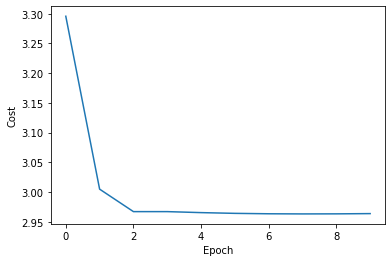

In [23]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [28]:
# calculating accuracy
accuracy = calc_accuracy(gray_train_data[:200], train_labels[:200], weights, biases)
print("accuracy of model is:", accuracy)

accuracy of model is: 33.0




### ***4) vectorization***

In [29]:
# calculating gradients of weights and biases using error backpropagation
def calculate_gradient_vectorized(train_image , weights, biases, labels):
  grad_w = []
  grad_b = []
  grad_a = []

  a = calculate_output(train_image, weights, biases)
  # initializing gradient matrixes and bias matrixes
  for i in range(len(weights)):
    grad_w.append(np.zeros(np.shape(weights[i][1])))
    grad_b.append(np.zeros(np.shape(biases[i][1])))
  
  grad_a.append(np.zeros(np.shape(a[1])))
  grad_a.append(np.zeros(np.shape(a[2])))
  

  # weighted sum matrix holds the weighted sum of each neuron in each layer 
  weighted_sum_matrix = []
  weighted_sum_matrix.append(weights[0][1] @ a[0] + biases[0][1])
  weighted_sum_matrix.append(weights[1][1] @ a[1] + biases[1][1])
  weighted_sum_matrix.append(weights[2][1] @ a[2] + biases[2][1])

  y = np.reshape(labels, (len(labels), -1))


  sigmoid_prime = sigmoid_derivative(weighted_sum_matrix[2])
  grad_w[2] += (sigmoid_prime * 2 *(a[3] - y)) @ (np.transpose(a[2]))

  sigmoid_prime = sigmoid_derivative(weighted_sum_matrix[2])
  grad_b[2] += 2*(a[3]- y) * sigmoid_prime

  sigmoid_prime  = sigmoid_derivative(weighted_sum_matrix[2])
  grad_a[1] += np.transpose(weights[2][1]) @ (2* (a[3] - y) * sigmoid_prime)

  # now we calculate gradients for third layer
  sigmoid_prime = sigmoid_derivative(weighted_sum_matrix[1])

  grad_w[1] = (grad_a[1][i] * sigmoid_prime) @ np.transpose(a[1])

  grad_b[1] = grad_a[1] * sigmoid_prime 

  grad_a[0] = np.transpose(weights[1][1]) @ (grad_a[1] * sigmoid_prime)

  ## now we calculate gradients for second layer

  sigmoid_prime = sigmoid_derivative(weighted_sum_matrix[0])

  grad_w[0] =  (grad_a[0] * sigmoid_prime) @ np.transpose(a[0])

  grad_b[0] = grad_a[0] * sigmoid_prime

  return grad_w, grad_b

In [51]:
epoch = 20
start1 = time.time() # start time of learning
weights1, biases1, costs1 = stochastic_gradient_descent(0, [1024, 16, 16, 4], gray_train_data[:200], train_labels[:200])
end1 = time.time() # wnd time of learning
print("total time of leaning model in seconds: ", end1 - start1)

total time of leaning model in seconds:  1.8418965339660645


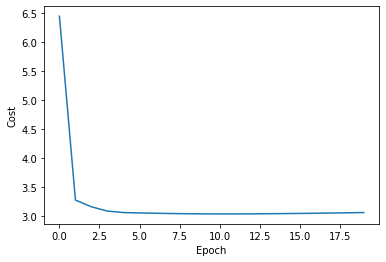

In [52]:
plt.plot(costs1)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [53]:
accuracy_vectorized = calc_accuracy(gray_train_data[:200], train_labels[:200], weights1, biases1)
print("accuracy of model using vectorized",accuracy_vectorized)

accuracy of model using vectorized 45.5


In [116]:
# Train network 10 times and return train, test accuracy and costs
def train_10_vectorized(vectorizedOrNot, dimension, train_data, train_labels):
    costs = []
    accuracies = []
    times = []
    for i in range(10):
        start = time.time()
        w, b, c = stochastic_gradient_descent(0, dimension, train_data, train_labels)
        end = time.time()
        duration = end - start
        costs.append(c)
        accuracy = calc_accuracy(train_data, train_labels ,w, b)
        accuracies.append(accuracy)
        times.append(duration)
    return  costs, accuracies, times

In [128]:
c, a, t = train_10_vectorized(0, [1024, 16, 16, 4], gray_train_data[:200], train_labels[:200])
print("avg acuuracy for 10 times :" , sum(a)/10)
print("avg time for 10 times:", sum(t)/10)

avg acuuracy for 10 times : 40.8
avg time for 10 times: 2.2731654167175295


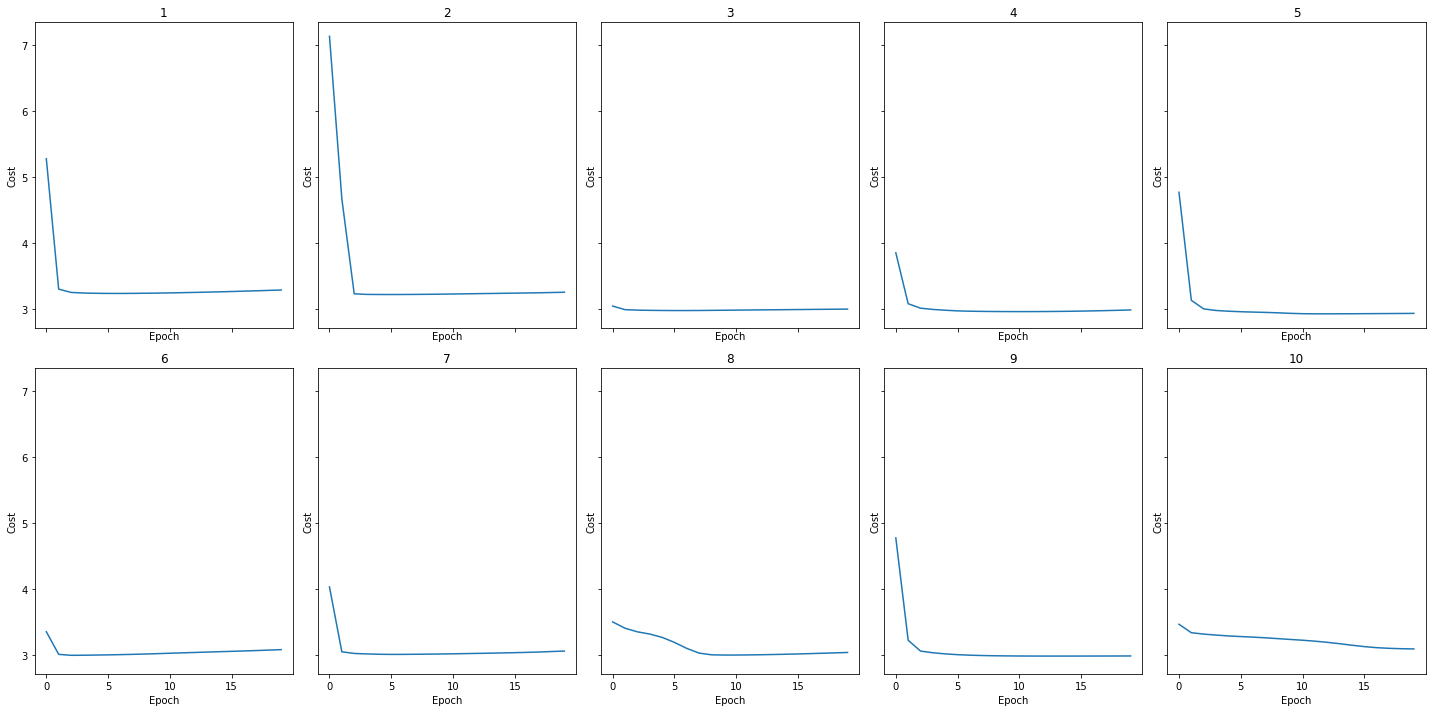

In [129]:

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20,10))
for i in range(2):
    for j in range(5):
        axs[i,j].plot(c[i*5+j])
        axs[i,j].set_title(i*5+j+1)
        axs[i,j].set(xlabel='Epoch', ylabel='Cost')
fig.tight_layout()
    

### ***5) testing the model***

In [130]:
learning_rate = 0.3
epochs = 20
batch_size = 16 

#first we shuffle both train data and labels
train_data_all, train_labels_all = shuffle_together(gray_train_data, train_labels)
# now we choose first 8000 elements of them
train_data_random = train_data_all[:800]
train_labels_random = train_labels_all[:800]

start = time.time() # start time of learning
weights_all, biases_all, costs_all = stochastic_gradient_descent(0, [1024, 16, 16, 4], train_data_random, train_labels_random)
end = time.time() # wnd time of learning
print("total time of leaning model in seconds: ", end - start)

accuracy_all = calc_accuracy(train_data_random,  train_labels_random, weights_all, biases_all)
print("accuracy of model is:", accuracy_all)

total time of leaning model in seconds:  11.83119535446167
accuracy of model is: 44.0


برای تعداد دیتای زیر 1000 این مدل بدرستی کار میکند
همانطور که مشخص است به ازای این تعداد ایپاک و داده مدل اورفیت میشود
به همین منظور با تعداد دیتای کمتر این مرحله را انجام داده ام
اما با تغییر هایپرپارامترها میتوان کاری کرد که مدل بدون اورفیت ترین شود

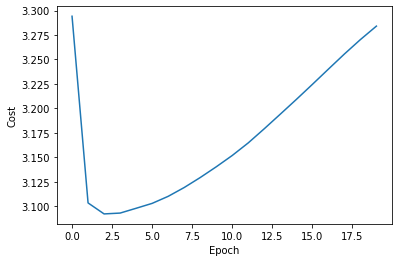

In [131]:
plt.plot(costs_all)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [132]:
learning_rate = 0.3
epochs = 40
batch_size = 16 

#first we shuffle both train data and labels
train_data_all, train_labels_all = shuffle_together(gray_train_data, train_labels)
# now we choose first 8000 elements of them
train_data_random = train_data_all[:8000]
train_labels_random = train_labels_all[:8000]

start = time.time() # start time of learning
weights_all, biases_all, costs_all = stochastic_gradient_descent(0, [1024, 16, 16, 4], train_data_random, train_labels_random)
end = time.time() # wnd time of learning
print("total time of leaning model in seconds: ", end - start)

accuracy_all = calc_accuracy(train_data_random,  train_labels_random, weights_all, biases_all)
print("accuracy of model is:", accuracy_all)

total time of leaning model in seconds:  60.7289776802063
accuracy of model is: 49.5


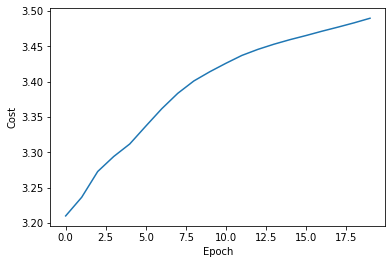

In [133]:
plt.plot(costs_all)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

مشخصا در روند الگوریتم مشکلی نبوده زیرا برای داده های کمتر درست کار میکند 
نتایج به ازای 400 داده تست به شکل زیر است:


In [137]:
c_test, a_test, t_test = train_10_vectorized(0, [1024, 16, 16, 4], gray_test_data[:400], test_labels[:400])
print("avg acuuracy for 10 times :" , sum(a)/10)
print("avg time for 10 times:", sum(t)/10)

avg acuuracy for 10 times : 40.8
avg time for 10 times: 2.2731654167175295


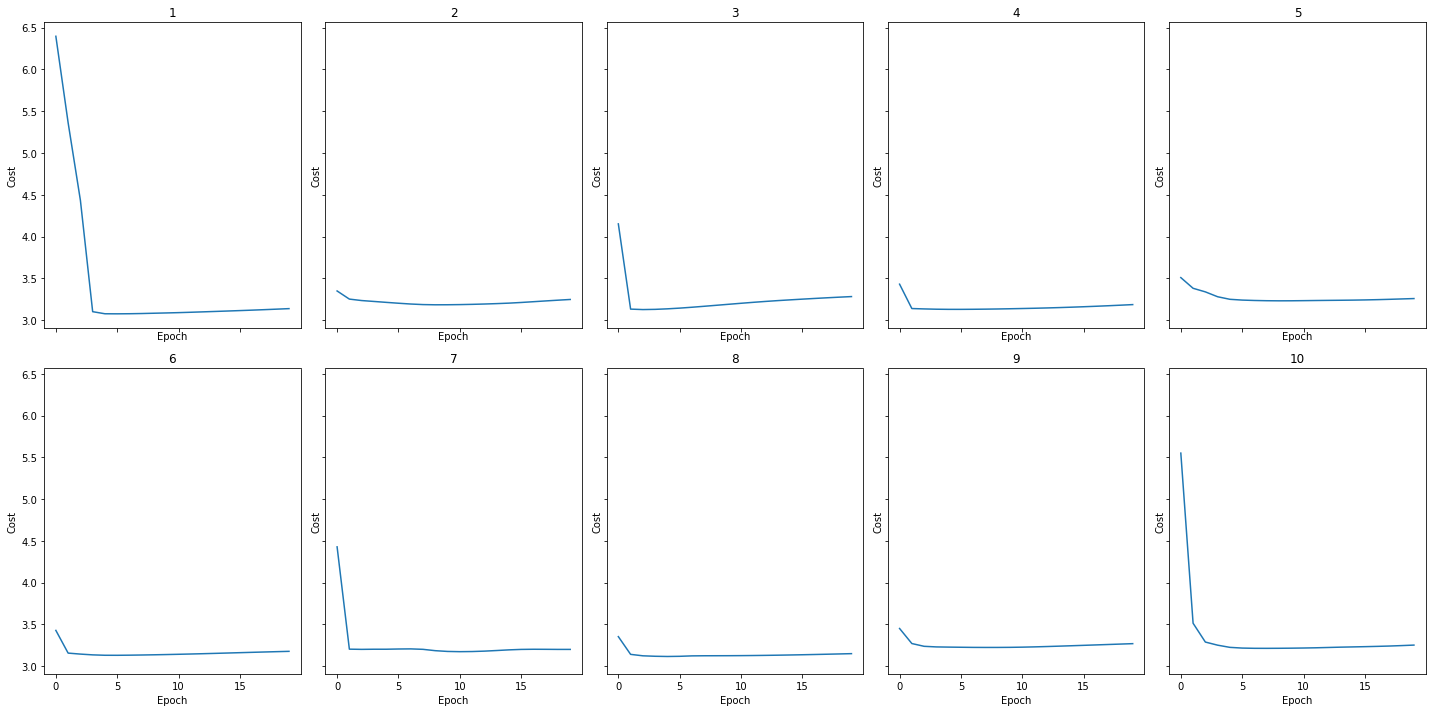

In [138]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20,10))
for i in range(2):
    for j in range(5):
        axs[i,j].plot(c_test[i*5+j])
        axs[i,j].set_title(i*5+j+1)
        axs[i,j].set(xlabel='Epoch', ylabel='Cost')
fig.tight_layout()